C:\Users\beher\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6012 - loss: 0.6569 - val_accuracy: 0.7634 - val_loss: 0.5377
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6878 - loss: 0.5999 - val_accuracy: 0.7924 - val_loss: 0.4981
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7131 - loss: 0.5695 - val_accuracy: 0.7511 - val_loss: 0.5295
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7218 - loss: 0.5594 - val_accuracy: 0.7905 - val_loss: 0.4821
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7490 - loss: 0.5314 - val_accuracy: 0.7789 - val_loss: 0.5029
Epoch 5: early stopping
Best Validation Accuracy: 0.7923920154571533
Epoch with Best Validation Accuracy: 2


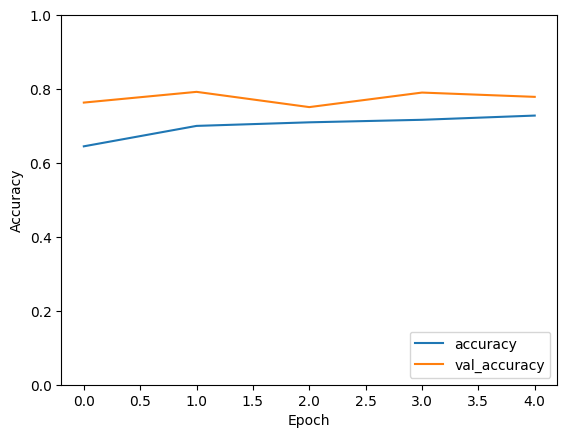

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7788523533204385
Precision: 0.7352297592997812
F1 Score: 0.7966804979253111
ROC AUC Score: 0.8642321007525848
Log Loss: 0.5026508279524521
Recall 0.869340232858991
Confusion Matrix:
[[536 242]
 [101 672]]
True Positive Rate (TPR): 0.869340232858991
False Positive Rate (FPR): 0.3110539845758355
False Negative Rate (FNR): 0.13065976714100905
True Negative Rate (TNR): 0.6889460154241646


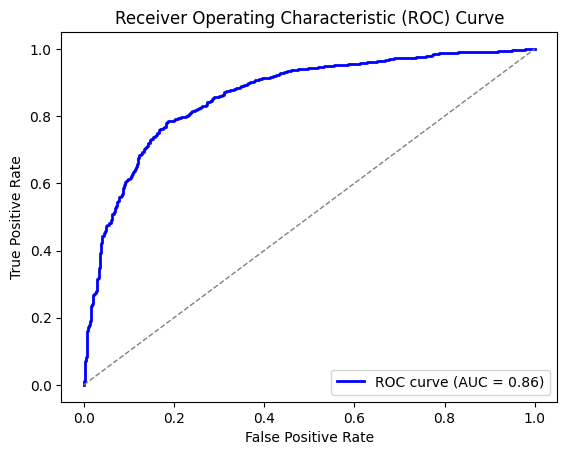

Confusion Matrix:
[[536 242]
 [101 672]]


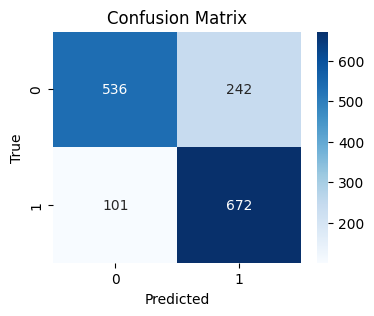

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, roc_auc_score, log_loss,roc_curve, recall_score
from tensorflow.keras.callbacks import EarlyStopping

# Read the data
train_data = pd.read_csv(r"C:\Users\beher\OneDrive\Desktop\NEW_METHOD\TRAINING_DATASET.csv")
test_data = pd.read_csv(r"C:\Users\beher\OneDrive\Desktop\NEW_METHOD\TESTING_DATASET.csv")

# Shuffle train_data and test_data
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target variable
X_train = train_data.drop(columns=["CLASS"])
y_train = train_data["CLASS"]
X_test = test_data.drop(columns=["CLASS"])
y_test = test_data["CLASS"]

# Identify categorical and numerical columns
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Fit and transform the training data
preprocessor.fit(X_train)
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Reshape the data for 1D CNN
X_train_reshaped = X_train_encoded.toarray().reshape(X_train_encoded.shape[0], X_train_encoded.shape[1], 1)
X_test_reshaped = X_test_encoded.toarray().reshape(X_test_encoded.shape[0], X_test_encoded.shape[1], 1)

# Define the model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

# Save the model weights
model.save_weights('CNN_trained.weights.h5')

# Get the best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print("Best Validation Accuracy:", best_val_accuracy)

# Get the epoch with the best validation accuracy
best_epoch = history.history['val_accuracy'].index(best_val_accuracy) + 1
print("Epoch with Best Validation Accuracy:", best_epoch)

# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on test data
y_test_pred_prob = model.predict(X_test_reshaped)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_prob)
logloss = log_loss(y_test, y_test_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Log Loss:", logloss)
print("Recall", recall)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate True Positive Rate (TPR), False Positive Rate (FPR), False Negative Rate (FNR), True Negative Rate (TNR)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
TNR = TN / (TN + FP)

print("True Positive Rate (TPR):", TPR)
print("False Positive Rate (FPR):", FPR)
print("False Negative Rate (FNR):", FNR)
print("True Negative Rate (TNR):", TNR)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix
import seaborn as sns
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [2]:
new_data = pd.read_csv(r"C:\Users\beher\OneDrive\Desktop\NEW_METHOD\NEW_TESTING.csv")
X_new_encoded = preprocessor.transform(new_data)
X_new_reshaped = X_new_encoded.toarray().reshape(X_new_encoded.shape[0], X_new_encoded.shape[1], 1)

# Predict probabilities for new data
y_pred_prob_new = model.predict(X_new_reshaped)

# Save predictions with probabilities
prob_df = pd.DataFrame(y_pred_prob_new, columns=['Probability'])
new_data_with_prob = pd.concat([new_data, prob_df], axis=1)
new_data_with_prob.to_csv('cnn_cat_lulc3_predictions_with_probabilities.csv', index=False)

24384/24384 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step


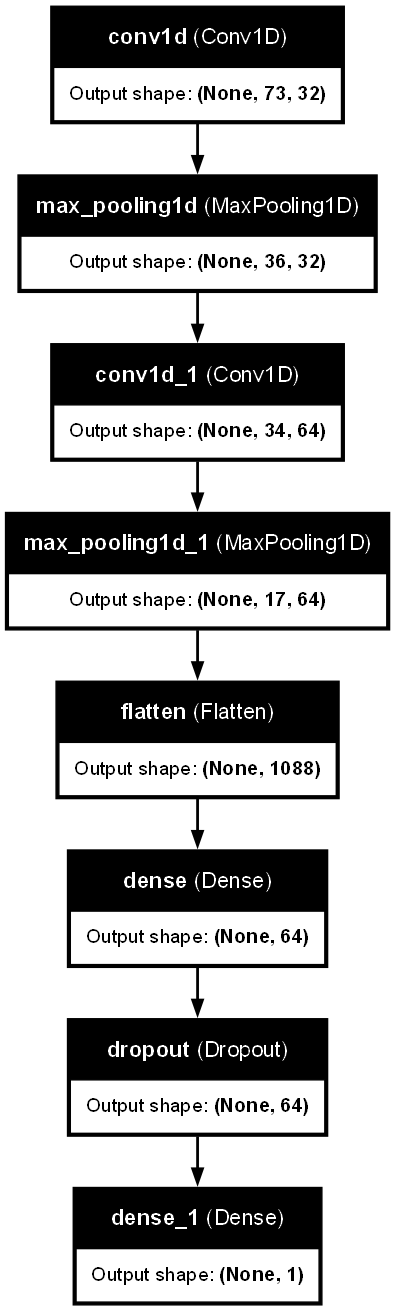

In [16]:
from tensorflow.keras.utils import plot_model

# Assuming `model` is your constructed CNN model
plot_model(model, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True, dpi=100)


In [17]:
# Assuming `model` is your constructed CNN model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 73, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 36, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 34, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          69,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 228,293 (891.77 KB)

 Trainable params: 76,097 (297.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 152,196 (594.52 KB)

In [2]:
new_data = pd.read_csv(r"C:\Users\beher\OneDrive\Desktop\NEW_METHOD\ls_merge_data.csv")
X_new_encoded = preprocessor.transform(new_data)
X_new_reshaped = X_new_encoded.toarray().reshape(X_new_encoded.shape[0], X_new_encoded.shape[1], 1)

# Predict probabilities for new data
y_pred_prob_new = model.predict(X_new_reshaped)

# Save predictions with probabilities
prob_df = pd.DataFrame(y_pred_prob_new, columns=['Probability'])
new_data_with_prob = pd.concat([new_data, prob_df], axis=1)
new_data_with_prob.to_csv('cnn_ls_lulc3_predictions_with_probabilities.csv', index=False)

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
